In [40]:
#import Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
from torch.utils.data.dataset import Dataset

### Initialize Parameters

In [ ]:
lr = 0.001
num_epochs = 25
batch_size = 128

#### torchvision is a package created for operating on images. It has data loaders for various common datasets such as CIFAR10, MNIST,etc. along with data transformers for images viz, torchvision.datasets and torch.utils.data.Dataloader

#### Output of torchvision datasets are PIL images of range [0,1]. So, we need to convert them in to tensors of normalized range [-1,1]

In [41]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True, num_workers=1)

classes = tuple(trainset.classes)

### Define network

In [52]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        #1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*4*4,120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120,80)
        self.fc2_bn = nn.BatchNorm1d(80)
        self.fc3 = nn.Linear(80,10)
    
    def forward(self,x):
        x = self.pool(self.conv1_bn(f.relu(self.conv1(x))))
        x = self.pool(self.conv2_bn(f.relu(self.conv2(x))))
        
        # If the size is a square you can only specify a single number
        x = x.view(-1,16*4*4)
        
        x = self.fc1_bn(f.relu(self.fc1(x)))
        x = self.fc2_bn(f.relu(self.fc2(x)))
        x = self.fc3(x)
        return f.softmax(x)

net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc2_bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


### Initialize Weights

In [53]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

net.apply(init_weights)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc2_bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

### Define loss function and optimizer

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr)
if torch.cuda.is_available():
    criterion = criterion.cuda()

### Training the network

In [47]:
train_acc = []
test_acc = []
for epoch in range(num_epochs):
    net = net.cuda()
    for i,  (inputs, labels) in enumerate(trainloader):
        
        optimizer.zero_grad()
        
        if i*labels.size(0) <= len(trainset)//2:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(),labels.cuda()
            outputs = net(inputs)
        else:
            new_images = torch.empty(inputs.shape)
            for i,img in enumerate(inputs):
                new_images[i] = 1 - img
            if torch.cuda.is_available():
                labels = labels.cuda()
                new_images = new_images.cuda()
            outputs = net(new_images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    train_correct = 0
    train_total = 0
    net = net.cpu()
    with torch.no_grad():
        for i, (images, labels) in enumerate(trainloader):
            
            if i*labels.size(0) <= len(trainset)//2:
                outputs = net(images)
            else:
                new_images = torch.empty(images.shape)
                for i,img in enumerate(images):
                    new_images[i] = 1 - img
                outputs = net(new_images)
            
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
    train_accuracy = (100*train_correct)/(train_total)
    train_acc.append(train_accuracy)
    
    correct = 0
    total = 0
    net = net.cpu()
    with torch.no_grad():
        for (images, labels) in testloader:
            
            if i*labels.size(0) <= len(testset)//2:
                outputs = net(images)
            else:
                new_images = torch.empty(images.shape)
                for i,img in enumerate(images):
                    new_images[i] = 1 - img
                outputs = net(new_images)
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = (100*correct)/(total)
    test_acc.append(test_accuracy)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%,  Test Accuracy: {test_accuracy:.2f}%")    

C:\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/25], Train Accuracy: 86.03%,  Test Accuracy: 98.22%
Epoch [2/25], Train Accuracy: 94.97%,  Test Accuracy: 98.55%
Epoch [3/25], Train Accuracy: 97.05%,  Test Accuracy: 98.74%
Epoch [4/25], Train Accuracy: 97.47%,  Test Accuracy: 98.68%
Epoch [5/25], Train Accuracy: 98.19%,  Test Accuracy: 98.73%
Epoch [6/25], Train Accuracy: 98.32%,  Test Accuracy: 98.78%
Epoch [7/25], Train Accuracy: 98.38%,  Test Accuracy: 98.82%
Epoch [8/25], Train Accuracy: 98.79%,  Test Accuracy: 98.74%
Epoch [9/25], Train Accuracy: 98.69%,  Test Accuracy: 98.87%
Epoch [10/25], Train Accuracy: 98.67%,  Test Accuracy: 98.92%
Epoch [11/25], Train Accuracy: 98.79%,  Test Accuracy: 98.72%
Epoch [12/25], Train Accuracy: 99.04%,  Test Accuracy: 98.85%
Epoch [13/25], Train Accuracy: 99.06%,  Test Accuracy: 98.93%
Epoch [14/25], Train Accuracy: 99.03%,  Test Accuracy: 98.78%
Epoch [15/25], Train Accuracy: 99.15%,  Test Accuracy: 98.89%
Epoch [16/25], Train Accuracy: 99.32%,  Test Accuracy: 98.79%
Epoch [17/25], Tr

### Evaluate  network on test data

In [48]:
correct = 0
total = 0
net = net.cpu()
with torch.no_grad():
    for (images, labels) in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy of the network on test images is: {(correct/total)*100:.2f}%')

C:\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Accuracy of the network on test images is: 98.79%


### Epoch-Accuracy Plot

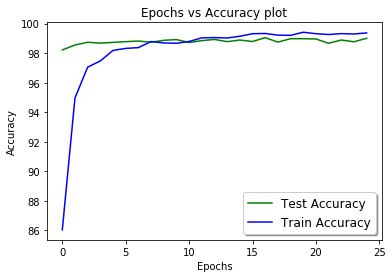

In [49]:
plt.plot(test_acc, color='green', label='Test Accuracy')
plt.plot(train_acc, color='blue', label='Train Accuracy')
plt.legend(loc='lower right', shadow=True, fontsize='large')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy plot')
plt.show()

### Evaluate Network on Negative test images

In [50]:
correct = 0
total = 0
net = net.cpu()
with torch.no_grad():
    for (images, labels) in testloader:
        new_images = torch.empty(images.shape)
        for i,img in enumerate(images):
            new_images[i] = 1 - img
        outputs = net(new_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy of the network on negative test images is: {(correct/total)*100:.2f}%')

C:\Anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final Accuracy of the network on negative test images is: 98.92%
